<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Работа-с-индексами" data-toc-modified-id="Работа-с-индексами-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Работа с индексами</a></span></li><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Создание новых признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

В данном проекте нам предстоит помочь компании «Чётенькое такси» спрогнозировать количество заказов такси на следующий час. 

Мы будем работать с датафреймом в котором содержится информация о количистве заказов в каждый момент времени

Для начала изучим данные и проведем их подготовку: проверим на пропуски и дубликаты, и при необходимости исправим. Так же проверим, что данные отсортированы по времени, и в случае чего, сами их отсортируем.

После этого проанализируем данные, выявим аномалии и удалим, если такие будут.

Далее мы разобьем наши данные на тренировочную и тестовую выборки в отношении 90/10. И с помощью моделей регрессии с различными гиперпараметрами проведем моделирование.

После всех расчетов, сравним показатели моделей, а именно - качество предсказания по метрике RMSE и выберем лучшую модель. С помощью нее сделаем прогноз на тестовых данных и посмотрим на точность (метрика RMSE должна быть <= 48).й.

In [1]:
!pip install --upgrade scikit-learn==1.2.2 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42

## Подготовка

### Загрузка данных

In [4]:
try:
    taxi_0 = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi_0 = pd.read_csv('C/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
taxi_0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi_0.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные в датафрейме представлены в нужном виде: колонка-индекс имеет тип datetime, количество заказов тип int. Названия столбцов записаны в змеином регистре, пропуски отсутствуют.

### Предобработка данных

####  Работа с индексами

Для начала отсортируем наши данные по возрастанию времени (по индексу). Это пригодится нам в дальнейшем, когда придется делить данные на выборки для анализа.

In [7]:
taxi_0.sort_index(inplace=True)

Так как мы будем прогнозировать количество заказов за час, то сделаем ресемплирование данных по 1 часу (вместо каждых 10 минут).

In [8]:
taxi_0 = taxi_0.resample('1h').sum()

In [9]:
taxi_0.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


####  Создание новых признаков

Для наилучшего прогноза добавим в наш датафрейм новые признаки. Для этого напишем функцию make_features(). Добавим колонки с годом, месяцем, днем, днем недели, часом. А также лаги и скользящее среднее.

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean']  = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

taxi = make_features(taxi_0, 24, 24)

In [11]:
taxi.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


####  Вывод

Индексы отсортированы и данные ресемплерованы по 1 часу. По мимо этого, были добавлены новые признаки, такие как год, месяц, лаги, скользящее среднее и другие. Предобработка данных успешно завершена.

## Анализ

Проанализруем наши данные. Для этого напишем функцию num_feature_plot(), которая будет отрисовывать наши признаки.

In [12]:
def num_feature_plot(df, num_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ЧИСЛОВЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список числовых колонок
    и для каждой колонки строит график boxplot()
    '''
    plt.figure(figsize=(16, 12))
    plt.suptitle('Распределение числовых признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in num_col:
        plt.subplot(2, 3, c)
        sns.boxplot(data=df, x=column)
        c+=1
    plt.show() 

In [13]:
taxi[['num_orders', 'year', 'month', 'day', 'dayofweek', 'hour']].describe()

,num_orders,year,month,day,dayofweek,hour
count,4416.000000,4416.0,4416.000000,4416.000000,4416.000000,4416.00000
mean,84.422781,2018.0,5.505435,15.836957,3.005435,11.50000
std,45.023853,0.0,1.713306,8.855229,1.990684,6.92297
min,0.000000,2018.0,3.000000,1.000000,0.000000,0.00000
25%,54.000000,2018.0,4.000000,8.000000,1.000000,5.75000
50%,78.000000,2018.0,5.500000,16.000000,3.000000,11.50000
75%,107.000000,2018.0,7.000000,23.250000,5.000000,17.25000
max,462.000000,2018.0,8.000000,31.000000,6.000000,23.00000


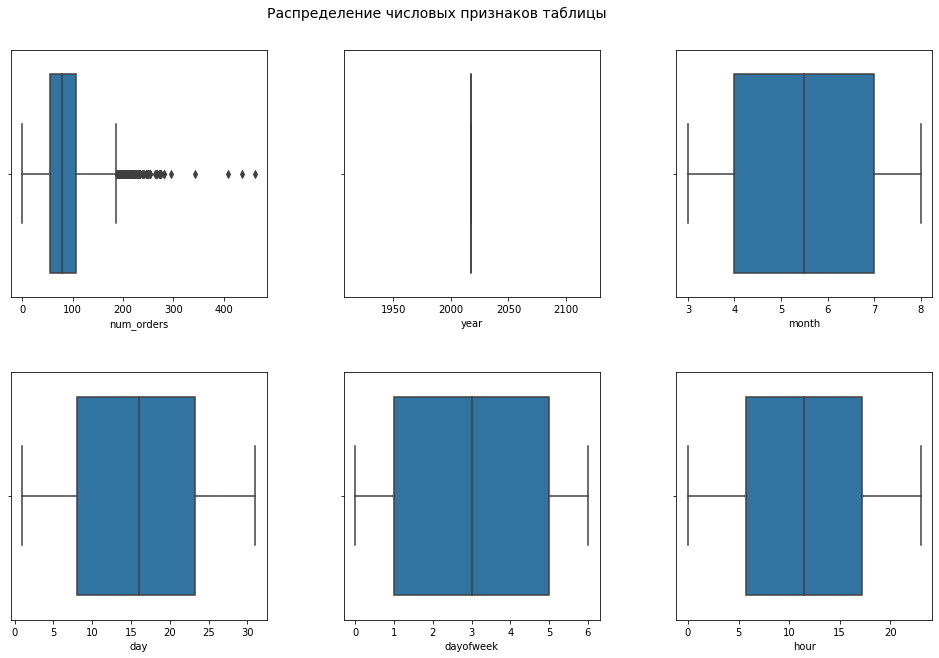

In [14]:
num_feature_plot(taxi, ['num_orders', 'year', 'month', 'day', 'dayofweek', 'hour'])

Видим, что в среднем на 1 час приходится около 80 заказов. Но встречаются необычные дни, когда заказов 200 и больше. Возможно это праздничные дни, когда люди возвращаются домой, или начало/конец лета, когда люди уезжают/приезжают из отпусков. 

Данные представлены за только за 2018 год. Поэтому колонку с годом можно удалить, тк она не будет являться инофрмативной для нас. 

Что касается месяца, то данные находятся в интервале с марта по август.

В остальном, у нас присутсвуют все дни месяцев, а так же все часы.

In [15]:
taxi = taxi.drop('year', axis=1)

Теперь нарисуем графики, которые отображают изменение нашего целового признака (количества заказов) от времени (по часу, по дню недели, по дню и по месяцу)

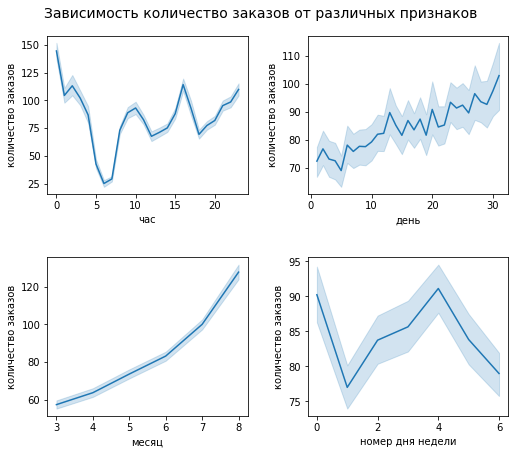

In [16]:
plt.figure(figsize=(8, 8))
plt.suptitle('Зависимость количество заказов от различных признаков', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.4)

c = 1
features = ['hour', 'day', 'month', 'dayofweek']
x = ['час', 'день', 'месяц', 'номер дня недели']

for feature in features:
    plt.subplot(2, 2, c)
    sns.lineplot(data=taxi, x =feature, y='num_orders')
    plt.ylabel('количество заказов')
    plt.xlabel(x[c-1])
    c+=1
plt.show()    

### Тренды и сезонность

Также проведем анализ наших данных при помощи модуля statsmodels.tsa.seasonal. Посмотрим на сезонность и тренд.

In [17]:
decomposed = seasonal_decompose(taxi['num_orders'])

<AxesSubplot:xlabel='datetime'>

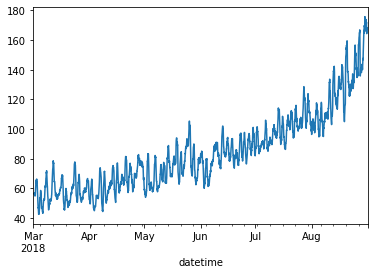

In [18]:
decomposed.trend['2018-03-01':'2018-08-31'].plot()

Присутствует тренд на увелечение числа поездок от марта к августу.

Теперь посмотрим на сезонность. Для этого проведем ресемплирование по дню.

In [19]:
taxi_1d = taxi_0.resample('1d').sum()
decomposed_1d = seasonal_decompose(taxi_1d['num_orders'])

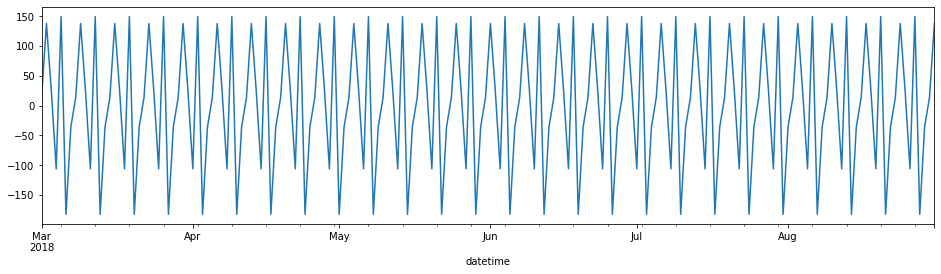

In [20]:
plt.figure(figsize=(16, 4))
decomposed_1d.seasonal.plot()
plt.show()

Видно, что сезонность меняется внутри месяца, поэтому стоит рассмотреть 1 месяц для лучшего понимания. Возьмем самый последний месяц, тк в это время было самое большое количество  поездок.

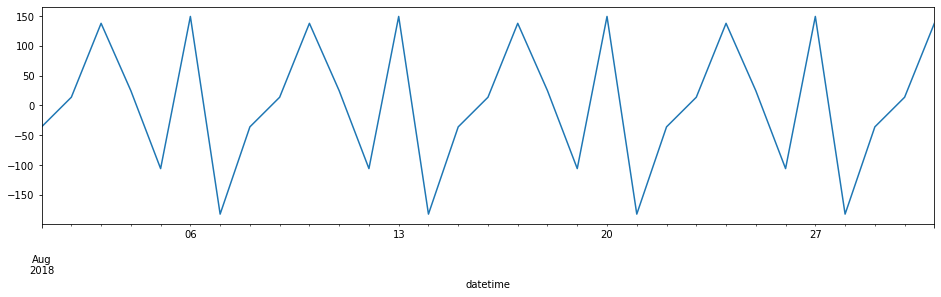

In [21]:
plt.figure(figsize=(16, 4))
decomposed_1d.seasonal['2018-08-01':'2018-08-31'].plot()
plt.show()

Присутствует сезонность внутри недели К понедельнику максмальная плотность заказов, потом она падает и снова выходит на пик к пятнице.

### Вывод

Видим, что наибольшее количество заказов приходится на время от 22 до 4. Это ночные заказы. На общественном транспорте добраться сложнее в такое время и альтернатив как правило не остается, поэтому наблюдается повышенный спрос на такси. Самый низкий спрос находится в промежутке с 5 до 7 утра. Возможно в это время меньше рейсов.

Количество заказов увеличивается от начала к концу месяца. Если в начале месяца заказов в среднем около 75, то к концу месяца их порядка 95.

Также видна зависимость от месяца. С каждым месяцем количество заказов возрастало: от 60 в среднем в марте, до 120 в августе. Это может быть связано с тем, что летом люди чаще летают на самолетах (многие летают в отпуска), а пик приходится на конец лета - август. 

Касательно дня недели, наибольшее количество заказов приходится на понедельник и пятницу. Это дни можно сапоставить с рабочим графиком. В начале рабочей недели люди улетают в командировки, а в конце недели возвращаются домой.


## Обучение

Для начала разобьем наши данные на обучающую и тестовую выборку в пропорции 90/10.

In [22]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Создадим пайплайн для кодирования наших признаков. Для этого разделим наши колонки на непрерывные и категориальные.

In [23]:
# создаём списки с названиями признаков
ohe_columns = ['month', 'day', 'dayofweek', 'hour']
num_columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),   
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Теперь создадим пайплайн 'pipe_final', который будет включать в себя пайплайн 'data_preprocessor' по предобработке входных признаков и этап моделирования. А дальше при помощи RandomSearchCV() найдем наиболее подходящую модель с лучшими гиперпараметрами, и высчитаем лучшую метрику RMSE.

В качестве моделей будем использовать модели регрессии LinearRegression, RandomForestRegressor, Ridge.

In [24]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  LinearRegression()
    )
])
param_grid = [
  
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели  RandomForestRegressor()
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split' : range(2, 20),
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__n_estimators': range(1, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

        # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha' : [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=TimeSeriesSplit(n_splits=5),
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print()
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['month', 'day', 'dayofweek',
                                                   'hour']),
                                                 ('num', MinMaxScaler(),
                          

## Тестирование

Теперь, когда лучшая модель найдена, сделаем прогноз на тестовых данных и посмотрим на метрику RMSE

In [25]:
y_test_pred = randomized_search.predict(X_test)

print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred)**0.5}')

Метрика RMSE на тестовой выборке: 43.00104379247978


Метрика получилось 43, что является хорошим результатом. Для наглядности визиуализируем наши предсказанные значения и тестовые, чтобы понимать точность модели.

Для этого создадим датафрейм, в котором будут тестовые данные и предсказанные.

In [26]:
data_pred = pd.DataFrame({'test': np.array(y_test), 
                   'pred': np.array(y_test_pred)
                   }, index=y_test.index)

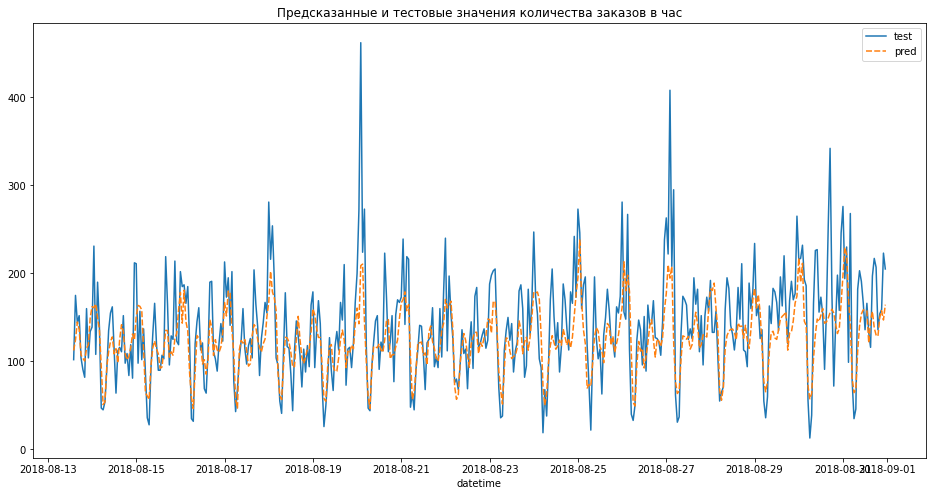

In [27]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=data_pred)
plt.title('Предсказанные и тестовые значения количества заказов в час')
plt.show()

Видно, что модель близка к истинным значениям, но немного занижает их. Это связанно с тем, что модель обучалась на данных преыдущих месяцев, где количество заказов было меньше. И мы наблюдали тренд роста по месяцам. Соответсвенно в последнем месяце самые высокие значения.

###  Вывод

Мы успешно создали модель для прогнозирования заказов на следующий час. Метрика RMSE составила около 43, что является допуском от заказчика (<=48).
Лучше всего с данной задачей справился RandomForestRegressor, так как в признаках присутсвуют не только непрерывные, но и категориальные.